# How much does contfunc dependents contribute to the overall LAS?

We are interested in looking at the contribution of functional dependents to the overall LAS score. To do this, we look at the correlation between the LAS score of functional dependency classes, plotted against the frequency ratio of the dependency class. If there is a correlation between how common the dependency class is in the language and how common the class is, we can draw the conclusion that the more common functional dependencies are in a language, the easier it is to parse.

We also expect that such a correlation cannot be found in content classes.

## Summary

There is such a correlation for the functional dependency class, and we lack the same correlation for content classes.

In [4]:
# Matplotlib
%matplotlib inline
import matplotlib as mpl
from matplotlib import pylab
import matplotlib.pyplot as plt
pylab.rcParams['figure.figsize'] = (10.0, 7.0)
mpl.style.use('ggplot')
from matplotlib.backends.backend_pgf import FigureCanvasPgf
mpl.backend_bases.register_backend('pgf', FigureCanvasPgf)

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

import sys, os
from os.path import join
sys.path.append("../tools/")
from collections import defaultdict

# Data management libraries
import pandas as pd
#import seaborn as sns

# Treebank utils, found in "../tools"
import udeval, udtree, lang_utils, dependency_classes

is_labeled = True
is_fine_grained_deprels = False
file_format = "conllx"
test_type = "test"

system_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/maltdefault_coarse_output_test_1-2/"
gold_output_base = "/Users/jimmy/dev/edu/nlp-rod/udeval/resources/universaldependencies1-2/universal-dependencies-1.2/"
file_prefix = "maltdefault"

system_files = lang_utils.get_system_output_paths(system_output_base, type_=test_type, format_=file_format)
gold_files = lang_utils.get_ud_paths(gold_output_base, type_=test_type, format_=file_format, coarse=True)

In [9]:
las = pd.Series.from_csv('../data/' + file_prefix + '.las.csv')
wlas = pd.Series.from_csv('../data/' + file_prefix + '.wlas.csv')
content_function_precision_recall = pd.DataFrame.from_csv('../data/' + file_prefix + '.content_function.precision_recall.csv', header=[0,1])
content_function_precision_recall

Content            Function          
                    precision    recall precision    recall
Arabic               0.716505  0.725658  0.825058  0.810317
Bulgarian            0.772891  0.776560  0.921854  0.916795
Croatian             0.674652  0.687672  0.820272  0.814315
Czech                0.778110  0.796339  0.890820  0.875164
Danish               0.690546  0.714676  0.898154  0.879813
English              0.784849  0.790791  0.921443  0.919656
Finnish              0.631938  0.635584  0.761481  0.762046
Gothic               0.616835  0.614317  0.804772  0.812409
Greek                0.651053  0.679462  0.894201  0.867292
Hebrew               0.697012  0.716423  0.922227  0.923529
Hindi                0.807023  0.814800  0.963245  0.962782
Italian              0.771964  0.774656  0.954366  0.954995
Norwegian            0.803790  0.803504  0.916245  0.931639
Old_Church_Slavonic  0.658627  0.666220  0.852444  0.836824
Persian              0.758404  0.769813  0.900920  0.880674
Polish               0.803204  0.804598  0.907010  0.903134
Portuguese           0.712555  0.730000  0.948301  0.941988
Slovenian            0.768859  0.781116  0.906062  0.899080
Spanish              0.692980  0.698730  0.918885  0.915484
Swedish              0.756714  0.764176  0.886657  0.874674

In [6]:
from collections import defaultdict

def label_ratio(trees, label_class):
    deprel_freqs = 0
    total_deprels = 0
    for tree in trees:
        for deprel in tree.deprels:
            label = deprel.split(":")[0]
            total_deprels += 1
            if label in label_class:
                deprel_freqs += 1
    deprel_dist = deprel_freqs / total_deprels
    return deprel_dist

def language_deprel_ratio(treebank_paths, label_class):
    lang_deprels = {}
    for lang, path in treebank_paths.items():
        lang_deprels[lang] = label_ratio(udtree.from_files(path), label_class)
    return lang_deprels


#lang_function_rels.to_csv('../data/' + file_prefix + '.function_dist.csv')
#lang_function_rels

In [16]:
lang_content_freq = pd.Series(language_deprel_ratio(gold_files, dependency_classes.content_dependents)).fillna(0)
lang_function_freq = pd.Series(language_deprel_ratio(gold_files, dependency_classes.function_dependents)).fillna(0)
content_function_freq = pd.concat([lang_content_freq, lang_function_freq], axis=1).rename(columns={0: 'C freq', 1: 'F freq'})
content_function_freq.to_csv('../data/content_function_freq.csv')

In [17]:
lang_measures = pd.concat([content_function_freq, wlas, content_function_precision_recall], axis=1)
lang_measures.rename(columns={0: 'WLAS', ('Content', 'precision'): 'C prec', ('Function', 'precision'): 'F prec', ('Content', 'recall'): 'C rec', ('Function', 'recall'): 'F rec'}, inplace=True)
lang_measures.to_csv('../data/maltdefault.lang_measures.csv')

0.714104429837


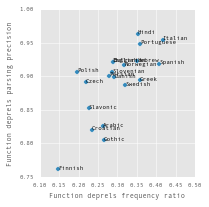

In [12]:
function_precision = lang_measures[['Function freq', 'F prec']]
function_precision.columns = ['Function deprels frequency ratio', 'Function deprels recall']

ax = function_precision.plot(kind='scatter', x='Function deprels frequency ratio', y='Function deprels recall', figsize=(3,3), fontsize=6)
#plt.plot(np.arange(0,0.6,0.1), (linr.slope*np.arange(0,0.6,0.1) + linr.intercept), '-')
plt.xlabel("Function deprels frequency ratio", fontsize=7)
plt.ylabel("Function deprels parsing precision", fontsize=7)
for lang, x, y in function_precision.itertuples():
    if lang == "Old_Church_Slavonic":
        lang = "Slavonic"
    ax.annotate(lang, (x, y), fontsize=6)

corr = function_precision.corr().ix[0,1]
print(corr)
plt.xlim(0.1, 0.5)
plt.ylim(0.75, 1.0)
#ax.annotate("R = {0:.2f}".format(corr), (0.12, 0.98))
plt.tight_layout()
plt.savefig("../paper/figures/function_ratio_vs_function_precision.pgf")

In [13]:
function_precision = lang_measures[['Content freq', 'C prec']]
content_precision.columns = ['Content deprels frequency ratio', 'Content deprels LAS']
ax = content_precision.plot(kind='scatter', x='Content deprels frequency ratio', y='Content deprels LAS', figsize=(3,3), fontsize=6)
plt.xlabel("Content deprels frequency ratio", fontsize=7)
plt.ylabel("Content deprels parsing precision", fontsize=7)
for lang, x, y in content_precision.itertuples():
    if lang == "Old_Church_Slavonic":
        lang = "Slavonic"
    ax.annotate(lang, (x, y), fontsize=6)
    
corr = content_precision.corr().ix[0,1]
print(corr)
#ax.annotate("$\\rho = {0:.2f}$".format(corr), (0.46, 0.84), size="x-large")
plt.tight_layout()
plt.savefig("../paper/figures/content_deprel_las_ratio_corr.pgf")

NameError: name 'content_precision' is not defined